In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataframe_forML.csv")
df.head()

,num_pages,ratings_count,text_reviews_count,edition_avgRating,added_toShelves,num_contributors,size_of_publisher,size_of_author,is_english,book_count,is_serie,has_edition,book_age,edition_year,edition_month,category_audio,category_hardcover,category_other,category_paperback
0,652,2095690,27591,4.57,4405980.0,2,3,2,1,2,1,1,1,2006,9,False,False,False,True
1,870,2153167,29221,4.50,4518536.0,2,3,2,1,1,1,1,1,2004,9,False,False,False,True
2,352,6333,244,4.05,7469.0,1,3,2,1,2,1,1,1,2003,11,False,True,False,False
3,435,2339585,36325,4.57,5223956.0,2,3,2,1,2,1,1,1,2004,5,False,False,False,True
4,2690,41428,164,4.72,172736.0,2,3,2,1,1,1,0,1,2004,9,False,False,False,True


In [3]:
features = ['num_pages', 'ratings_count', 'text_reviews_count',
       'added_toShelves', 'num_contributors', 'size_of_publisher',
       'size_of_author', 'is_english', 'book_count', 'is_serie', 'has_edition',
       'book_age', 'edition_year', 'edition_month', 'category_audio',
       'category_hardcover', 'category_other', 'category_paperback']

In [17]:
# split data into 70% train and 30% test
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=42)

# scale the data 
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

books_train_L = scaler_std.fit_transform(df_train)
books_train_L = scaler_minmax.fit_transform(df_test)
target = "edition_avgRating"
X_train = df_train[features]
Y_train = df_train[target]
X_test = df_test[features]
Y_test = df_test[target]

In [19]:
params = {
    "n_estimators": 1000,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [21]:

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)

mse = mean_squared_error(Y_test, reg.predict(X_test))

In [22]:
mse

0.10592396948016349

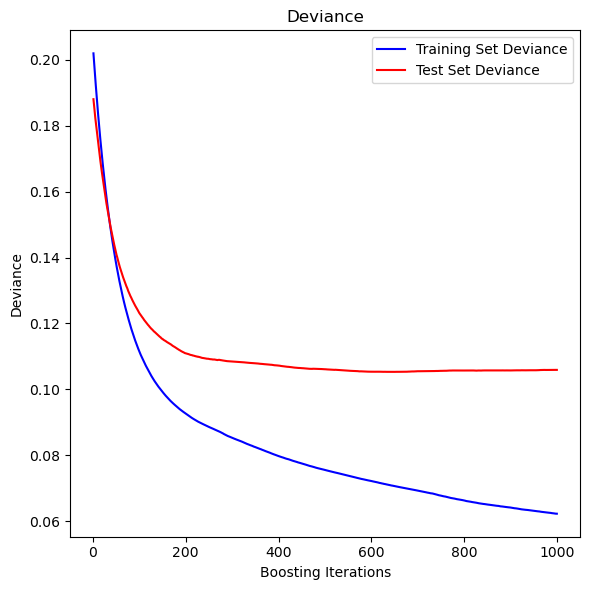

In [23]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(Y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

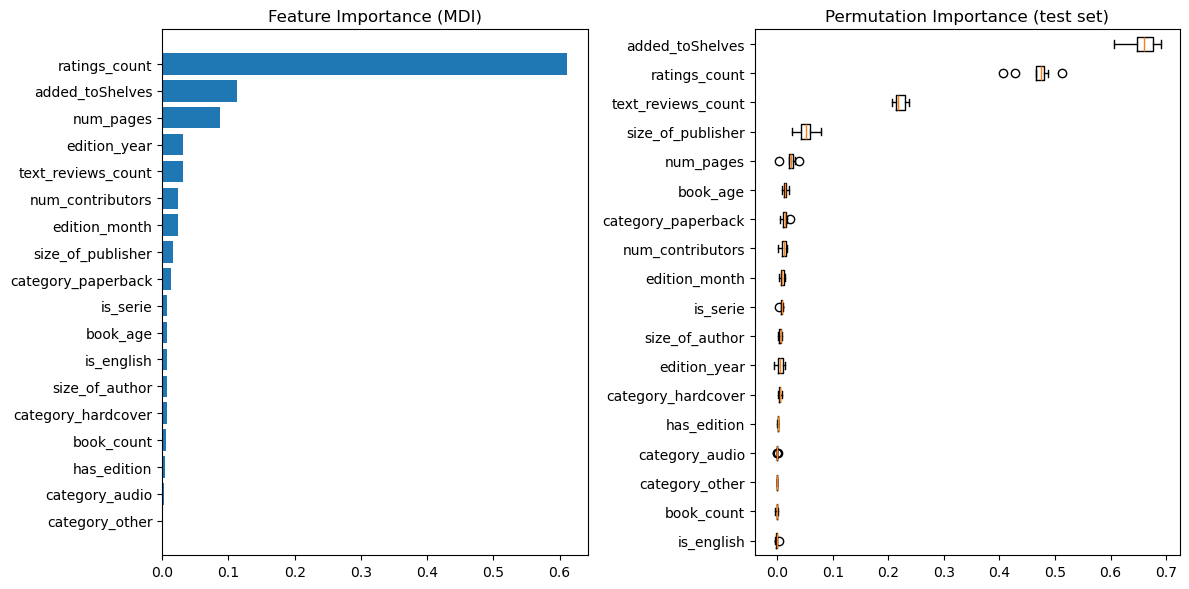

In [24]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [25]:
r2_score(Y_test, reg.predict(X_test))

0.44097305730085024

In [26]:
pred_reg = reg.predict(X_test)

In [27]:
pred_reg

array([3.9374055 , 3.89129299, 4.08640556, ..., 3.69057517, 4.00735971,
       4.07722644])

In [28]:
Y_test

8663     3.90
483      3.79
8403     4.08
6382     4.10
1844     3.82
         ... 
7940     3.90
10245    4.15
8008     3.75
6270     3.91
1414     4.57
Name: edition_avgRating, Length: 3339, dtype: float64

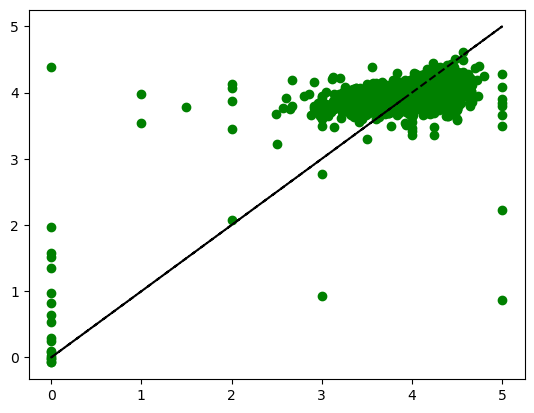

In [29]:
plt.scatter(Y_test, pred_reg, color='g')  # Scatter plot of true values (Y_test) vs predicted values (pred_reg)
plt.plot(Y_test, Y_test, color='k', linestyle='--') 

<Axes: >

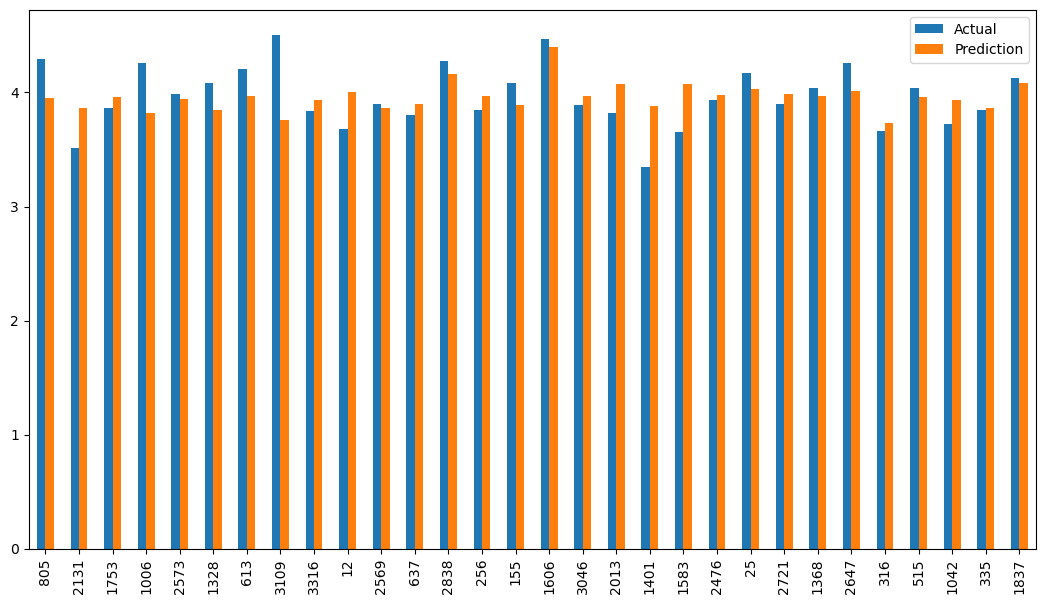

In [30]:
prd = pd.DataFrame({'Actual': Y_test.tolist(), 'Prediction': pred_reg.tolist()}).sample(30)
prd.head(10)
prd.plot(kind='bar', figsize=(13, 7))